<a href="https://colab.research.google.com/github/dsainvg/Tic-tac-toe-model/blob/main/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Board

In [1]:
import torch

class Board:
    def __init__(self):
        self.board = torch.zeros(9, dtype=torch.float32)
        self.sum = 0
        self.game = []

    def printBoard(self):
        for i in range(3):
            print(self.board[i*3:(i+1)*3])

    def _play(self, id, val):
        if self.board[val].item() == 0:
            self.sum += 1
            self.board[val] = id
            self.game.append((id, val))
            return True
        return False

    def _checkWin(self, id, val):
        b = self.board  # shorthand for readability
        match val:
            case 0:
                if (b[0] == b[1]).item() and (b[1] == b[2]).item() and (b[0] == id).item():
                    return True
                if (b[0] == b[3]).item() and (b[3] == b[6]).item() and (b[0] == id).item():
                    return True
                if (b[0] == b[4]).item() and (b[4] == b[8]).item() and (b[0] == id).item():
                    return True
            case 1:
                if (b[0] == b[1]).item() and (b[1] == b[2]).item() and (b[0] == id).item():
                    return True
                if (b[1] == b[4]).item() and (b[4] == b[7]).item() and (b[1] == id).item():
                    return True
            case 2:
                if (b[0] == b[1]).item() and (b[1] == b[2]).item() and (b[0] == id).item():
                    return True
                if (b[2] == b[5]).item() and (b[5] == b[8]).item() and (b[2] == id).item():
                    return True
                if (b[2] == b[4]).item() and (b[4] == b[6]).item() and (b[2] == id).item():
                    return True
            case 3:
                if (b[3] == b[4]).item() and (b[4] == b[5]).item() and (b[3] == id).item():
                    return True
                if (b[0] == b[3]).item() and (b[3] == b[6]).item() and (b[0] == id).item():
                    return True
            case 4:
                if (b[3] == b[4]).item() and (b[4] == b[5]).item() and (b[3] == id).item():
                    return True
                if (b[1] == b[4]).item() and (b[4] == b[7]).item() and (b[1] == id).item():
                    return True
                if (b[0] == b[4]).item() and (b[4] == b[8]).item() and (b[0] == id).item():
                    return True
                if (b[2] == b[4]).item() and (b[4] == b[6]).item() and (b[2] == id).item():
                    return True
            case 5:
                if (b[3] == b[4]).item() and (b[4] == b[5]).item() and (b[3] == id).item():
                    return True
                if (b[2] == b[5]).item() and (b[5] == b[8]).item() and (b[2] == id).item():
                    return True
            case 6:
                if (b[6] == b[7]).item() and (b[7] == b[8]).item() and (b[6] == id).item():
                    return True
                if (b[0] == b[3]).item() and (b[3] == b[6]).item() and (b[0] == id).item():
                    return True
                if (b[2] == b[4]).item() and (b[4] == b[6]).item() and (b[2] == id).item():
                    return True
            case 7:
                if (b[6] == b[7]).item() and (b[7] == b[8]).item() and (b[6] == id).item():
                    return True
                if (b[1] == b[4]).item() and (b[4] == b[7]).item() and (b[1] == id).item():
                    return True
            case 8:
                if (b[6] == b[7]).item() and (b[7] == b[8]).item() and (b[6] == id).item():
                    return True
                if (b[2] == b[5]).item() and (b[5] == b[8]).item() and (b[2] == id).item():
                    return True
                if (b[0] == b[4]).item() and (b[4] == b[8]).item() and (b[0] == id).item():
                    return True
        return False

    def play(self, id, val):
        if self._play(id, val):
            if self._checkWin(id,val):
                return True,"win"
            if self.sum == 9:
                return True,"draw"
            return False,"none"
        return True,"invalid"

    def clear(self):
        self.board = torch.zeros(9, dtype=torch.float32)
        self.sum = 0
        self.game = []

    @property
    def board_state(self):
        return self.board

    @property
    def game_state(self):
        return self.game


# Imports

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import random
import torch
import torch.nn as nn
from torch.distributions import Categorical
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Board setup and test
board = Board()
# board.printBoard()
# board.board_state

# MODEL

In [ ]:
# Hyper-parameters
input_size = 9
hidden_sizes = (256,512,64,32)
num_classes = 9
num_epochs = 5000  # Increased from 2500
# Initialize 8 boards for parallel training
num_parallel_boards = 32
game_chances = 9
temperature = 0.60
learning_rate = 7e-4
gamma = 0.85
t_end = 0.98
random_t_start = 0.45
random_t_add = 0.5
# Reward function
reward = {"Win":2,"Lost":-1.9,"Draw":0.05}

### NEURALNET DESIGN

In [5]:
# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(2*input_size, hidden_sizes[0])
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.l3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.l4 = nn.Linear(hidden_sizes[2], hidden_sizes[3])
        self.l5 = nn.Linear(hidden_sizes[3], num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        xin = torch.stack((self.relu(x), self.relu(-x)), dim=2).flatten(start_dim=1)
        logits = torch.zeros_like(x)  # Create a tensor of all 0s
        logits = logits.masked_fill(x != 0, float('-inf'))
        out = self.l1(xin)
        out = self.relu(out)
        out = self.l2(out)
        out = self.relu(out)
        out = self.l3(out)
        out = self.relu(out)
        out = self.l4(out)
        out = self.relu(out)
        out = self.l5(out)
        out = out + logits
        out = self.softmax(out)
        return out

model = NeuralNet(input_size, hidden_sizes, num_classes).to(device)

## Tests

In [ ]:
# Test model by checking if it avoids already used positions
board.clear()
print("Empty board:")
board.printBoard()

# Make a few moves manually
board.play(1, 0)  # X in position 0
board.play(-1, 4)  # O in position 4
print("\nBoard after manual moves:")
board.printBoard()

# Test model prediction on this board state
with torch.no_grad():
    # Determine turn
    x_count = (board.board_state == 1).sum().item()
    o_count = (board.board_state == -1).sum().item()
    turn = -1 if x_count == o_count else 1
    
    prediction = model((board.board_state * turn).unsqueeze(0).to(device))
    print(f"\nModel probabilities for each position:")
    for i in range(9):
        status = "OCCUPIED" if board.board_state[i] != 0 else "FREE"
        print(f"Position {i}: {prediction[0][i].item():.4f} ({status})")

    # Check if model assigns near-zero probability to occupied positions
    occupied_positions = (board.board_state != 0).nonzero().flatten()
    free_positions = (board.board_state == 0).nonzero().flatten()

    print(f"\nOccupied positions: {occupied_positions.tolist()}")
    print(f"Probabilities for occupied positions: {[prediction[0][i].item() for i in occupied_positions]}")
    print(f"Free positions: {free_positions.tolist()}")
    print(f"Probabilities for free positions: {[prediction[0][i].item() for i in free_positions]}")

Empty board:
tensor([0., 0., 0.])
tensor([0., 0., 0.])
tensor([0., 0., 0.])

Board after manual moves:
tensor([1., 0., 0.])
tensor([ 0., -1.,  0.])
tensor([0., 0., 0.])

Model probabilities for each position:
Position 0: 0.0000 (OCCUPIED)
Position 1: 0.1545 (FREE)
Position 2: 0.1465 (FREE)
Position 3: 0.1507 (FREE)
Position 4: 0.0000 (OCCUPIED)
Position 5: 0.1349 (FREE)
Position 6: 0.1373 (FREE)
Position 7: 0.1272 (FREE)
Position 8: 0.1489 (FREE)

Occupied positions: [0, 4]
Probabilities for occupied positions: [0.0, 0.0]
Free positions: [1, 2, 3, 5, 6, 7, 8]
Probabilities for free positions: [0.15452691912651062, 0.14648637175559998, 0.1507011204957962, 0.13491950929164886, 0.1372935026884079, 0.1272171437740326, 0.14885543286800385]


## Training

In [ ]:
# Fully Optimized: True Batch Processing with Gradient Tracking
# Processes all 8 boards in a single batched forward pass with gradients

# Loss and optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_histories = {"avg":[],"cum":[]}
# Pre-compute discount cache (outside training loop)
discount_cache = {}
for length in range(1, game_chances + 1):
    discount_cache[length] = torch.pow(gamma, torch.arange(length, device=device, dtype=torch.float32))
cummulative_loss = 0.0
avg100 = 0.0

parallel_boards = [Board() for _ in range(num_parallel_boards)]

# Storage for all game histories
all_game_histories = []

# 3) Training loop with true batched parallel processing
for epoch in range(num_epochs):
    # Clear all boards
    for board in parallel_boards:
        board.clear()

    # Generate active players for all boards
    active_players = [1 if random.random() < 0.5 else 0 for _ in range(num_parallel_boards)]

    # Track game data for each board
    all_gamequeus = [[] for _ in range(num_parallel_boards)]
    all_boards_states = [[] for _ in range(num_parallel_boards)]
    game_finished = [False] * num_parallel_boards
    final_results = [None] * num_parallel_boards  # (status, win) for each board

    # Play games on all boards
    for i in range(game_chances):
        # Collect active board indices
        active_board_indices = [idx for idx, finished in enumerate(game_finished) if not finished]

        if not active_board_indices:
            break

        # Store board states for all active boards
        for board_idx in active_board_indices:
            all_boards_states[board_idx].append(parallel_boards[board_idx].board_state.clone())

        # BATCH PROCESS: Stack all active board states and run through model once
        batch_states = torch.stack([parallel_boards[idx].board_state for idx in active_board_indices]).to(device)
        
        # [STRUCTURAL FIX] Normalize perspective: 
        # Multiply board by current player ID so the model always sees "My Pieces" as 1
        current_player_val = 2*(i%2) - 1
        batch_states = batch_states * current_player_val

        batch_predictions = model(batch_states)  # Single forward pass with gradients!

        # Process each board's prediction from the batch
        for batch_idx, board_idx in enumerate(active_board_indices):
            board = parallel_boards[board_idx]
            active_player = active_players[board_idx]

            # Extract this board's prediction from batch
            y = batch_predictions[batch_idx].unsqueeze(0)

            # Create mask for valid moves
            valid_mask = (board.board_state == 0).float().unsqueeze(0).to(device)
            num_valid = valid_mask.sum()

            # Mix model predictions with uniform over valid moves
            t = temperature + (epoch / num_epochs) * 2 * (1 - temperature)
            t = min(t, t_end)
            if active_player != i%2:
                t = random_t_start + (epoch / num_epochs) * random_t_add
            uniform_prob = valid_mask / num_valid
            y = y * t + uniform_prob * (1 - t)
            m = Categorical(probs=y)
            Y_out = m.sample()

            # Make move
            status, win = board.play(2*(i%2) - 1, Y_out.item())

            # Store log probability if this is the active player's turn
            if i % 2 == active_player:
                log_prob = m.log_prob(Y_out)
                all_gamequeus[board_idx].append((i, log_prob))

            # Check if game finished
            if status:
                game_finished[board_idx] = True
                final_results[board_idx] = (status, win)

    # Calculate losses for all boards and save game histories
    all_losses = []

    for board_idx in range(num_parallel_boards):
        gamequeue = all_gamequeus[board_idx]
        boards_states = all_boards_states[board_idx]

        if final_results[board_idx] is None:
            continue

        status, win = final_results[board_idx]
        active_player = active_players[board_idx]

        if win == "invalid":
            # Skip invalid moves (you could also penalize them)
            if len(boards_states) > 0:
                print(f"Invalid move made on board {board_idx}!")
                print("Board state:\n", boards_states[-1].reshape(3,3))
            continue
        elif len(gamequeue) == 0:
            continue
        else:
            # Save game history for this board
            game_history = {
                'epoch': epoch,
                'board_idx': board_idx,
                'active_player': active_player,
                'game_state': parallel_boards[board_idx].game_state.copy(),  # List of (id, position) moves
                'result': win,
                'reward': reward["Draw"] if win == "draw" else (reward["Win"] if (len(boards_states) - 1) % 2 == active_player else reward["Lost"])
            }
            all_game_histories.append(game_history)

            if win == "draw":
                reward_value = reward["Draw"]
            else:
                # Determine final move index
                final_i = len(boards_states) - 1
                reward_value = reward["Win"] if (final_i % 2) == active_player else reward["Lost"]

            # Stack all log_probs into a single tensor
            log_probs = torch.stack([lp for _, lp in gamequeue[::-1]])

            # Use cached discounts
            discounts = discount_cache[len(gamequeue)]

            # Vectorized loss calculation
            loss = -(discounts * reward_value * log_probs).sum() / len(gamequeue)
            all_losses.append(loss)

    # Average loss across all parallel boards and update
    if len(all_losses) > 0:
        # Zero gradients
        optimizer.zero_grad()

        # Average the losses
        total_loss = torch.stack(all_losses).mean()

        # Backward pass
        total_loss.backward()

        # Update weights
        optimizer.step()

        with torch.no_grad():
            cummulative_loss += total_loss.item()
            avg100 += total_loss.item()
        if (epoch+1) % 100 == 0:
            loss_histories["avg"].append(avg100)
            loss_histories["cum"].append(cummulative_loss/(epoch+1)) # Fixed: Appending to 'cum' history
            print('epoch ', epoch+1, ': loss = ', total_loss.item(),'; avg loss = ', cummulative_loss/(epoch+1),f"; Avg loss of last 100 is {avg100}", f'; boards processed = {len(all_losses)}')
            avg100 = 0.0

epoch  100 : loss =  0.4081612229347229 ; avg loss =  0.22257611602544786 ; Avg loss of last 100 is 22.257611602544785 ; boards processed = 32
epoch  200 : loss =  1.3933370113372803 ; avg loss =  0.010720113283023238 ; Avg loss of last 100 is -20.113588945940137 ; boards processed = 32
epoch  300 : loss =  -0.9706025123596191 ; avg loss =  -0.049711979211618504 ; Avg loss of last 100 is -17.0576164200902 ; boards processed = 32
epoch  400 : loss =  0.07550862431526184 ; avg loss =  -0.0601743202120997 ; Avg loss of last 100 is -9.15613432135433 ; boards processed = 32
epoch  500 : loss =  -0.20406611263751984 ; avg loss =  -0.06820305510796607 ; Avg loss of last 100 is -10.031799469143152 ; boards processed = 32
epoch  600 : loss =  0.37095803022384644 ; avg loss =  -0.057557190931402144 ; Avg loss of last 100 is -0.4327870048582554 ; boards processed = 32
epoch  700 : loss =  0.4042222797870636 ; avg loss =  -0.04300154765402632 ; Avg loss of last 100 is 4.433231201022863 ; boards pr

# Saving of model

In [ ]:

def print_board_nice(board):
    """Print board in a nice format"""
    print("\nCurrent Board State:")
    print("  0 | 1 | 2")
    print("  ---------")
    print("  3 | 4 | 5")
    print("  ---------")
    print("  6 | 7 | 8")
    print()

    state = board.board_state
    for i in range(3):
        row = []
        for j in range(3):
            idx = i * 3 + j
            val = state[idx].item()
            if val == 0:
                row.append(str(idx))
            elif val == 1:
                row.append('X')
            else:
                row.append('O')
        print(f"  {row[0]} | {row[1]} | {row[2]}")
        if i < 2:
            print("  ---------")
    print()

def get_model_prediction(model, board):
    """Get model's prediction and show probabilities"""
    with torch.no_grad():
        # Determine whose turn it is based on piece count (assuming Player -1 moves first as per your loop logic)
        x_count = (board.board_state == 1).sum().item()
        o_count = (board.board_state == -1).sum().item()
        turn = -1 if x_count == o_count else 1

        # Normalize perspective and send to device
        board_tensor = (board.board_state * turn).unsqueeze(0).to(device)
        prediction = model(board_tensor)

        print("\nModel's Move Probabilities:")
        for i in range(9):
            status = "OCCUPIED" if board.board_state[i] != 0 else "FREE"
            print(f"Position {i}: {prediction[0][i].item():.4f} ({status})")

        # Get best move
        valid_positions = (board.board_state == 0).nonzero().flatten()
        if len(valid_positions) > 0:
            probs = prediction[0].clone()
            for i in range(9):
                if board.board_state[i] != 0:
                    probs[i] = -1
            best_move = probs.argmax().item()
            print(f"\nAI chooses position: {best_move}")
            return best_move
        return None

def ai_vs_ai(model=model, num_games=5, verbose=True):
    print(f"\n{'='*50}")
    print(f"AI vs AI - {num_games} games")
    print(f"{'='*50}\n")

    wins = 0
    draws = 0

    for game_num in range(num_games):
        board = Board()
        print(f"\n{'='*50}")
        print(f"Game {game_num + 1}:")
        print(f"{'='*50}")
        current_player = 1 if game_num % 2 == 0 else -1

        # Show initial empty board
        print_board_nice(board)

        for turn in range(9):
            print(f"\nTurn {turn + 1} - Player {'X' if current_player == 1 else 'O'}'s move:")

            # Get model's move
            with torch.no_grad():
                # [STRUCTURAL FIX] Normalize perspective and ensure device is correct
                board_tensor = (board.board_state * current_player).unsqueeze(0).to(device)
                prediction = model(board_tensor)

                # Get best valid move
                valid_positions = (board.board_state == 0).nonzero().flatten()
                if len(valid_positions) == 0:
                    break

                probs = prediction[0].clone()
                for i in range(9):
                    if board.board_state[i] != 0:
                        probs[i] = -1
                move = probs.argmax().item()

            print(f"AI chooses position: {move}")
            status, result = board.play(current_player, move)

            # Show board after each move
            print_board_nice(board)

            if result == "win":
                print(f"🎉 Player {'X' if current_player == 1 else 'O'} won!")
                if current_player == 1:
                    wins += 1
                break
            elif result == "draw":
                print("🤝 It's a draw!")
                draws += 1
                break

            current_player = -current_player

    print(f"\n{'='*50}")
    print(f"Final Results:")
    print(f"X wins: {wins}")
    print(f"O wins: {num_games - wins - draws}")
    print(f"Draws: {draws}")
    print(f"{'='*50}\n")
ai_vs_ai()


AI vs AI - 5 games


Game 1:

Current Board State:
  0 | 1 | 2
  ---------
  3 | 4 | 5
  ---------
  6 | 7 | 8

  0 | 1 | 2
  ---------
  3 | 4 | 5
  ---------
  6 | 7 | 8


Turn 1 - Player X's move:
AI chooses position: 4

Current Board State:
  0 | 1 | 2
  ---------
  3 | 4 | 5
  ---------
  6 | 7 | 8

  0 | 1 | 2
  ---------
  3 | X | 5
  ---------
  6 | 7 | 8


Turn 2 - Player O's move:
AI chooses position: 0

Current Board State:
  0 | 1 | 2
  ---------
  3 | 4 | 5
  ---------
  6 | 7 | 8

  O | 1 | 2
  ---------
  3 | X | 5
  ---------
  6 | 7 | 8


Turn 3 - Player X's move:
AI chooses position: 6

Current Board State:
  0 | 1 | 2
  ---------
  3 | 4 | 5
  ---------
  6 | 7 | 8

  O | 1 | 2
  ---------
  3 | X | 5
  ---------
  X | 7 | 8


Turn 4 - Player O's move:
AI chooses position: 2

Current Board State:
  0 | 1 | 2
  ---------
  3 | 4 | 5
  ---------
  6 | 7 | 8

  O | 1 | O
  ---------
  3 | X | 5
  ---------
  X | 7 | 8


Turn 5 - Player X's move:
AI chooses position: 3


In [9]:
import pickle
# Save model and game histories
print(f"Saving model and {len(all_game_histories)} game histories to Google Drive...")

# Save model
model_filename = '/content/drive/MyDrive/models/model.pth'
torch.save(model.state_dict(), model_filename)
print(f"Model saved to {model_filename}")

# Save game histories
histories_filename = '/content/drive/MyDrive/models/game_histories.pkl'
with open(histories_filename, 'wb') as f:
    pickle.dump(all_game_histories, f)
print(f"Game histories saved to {histories_filename}")

Saving model and 80000 game histories to Google Drive...
Model saved to /content/drive/MyDrive/models/model.pth
Game histories saved to /content/drive/MyDrive/models/game_histories.pkl


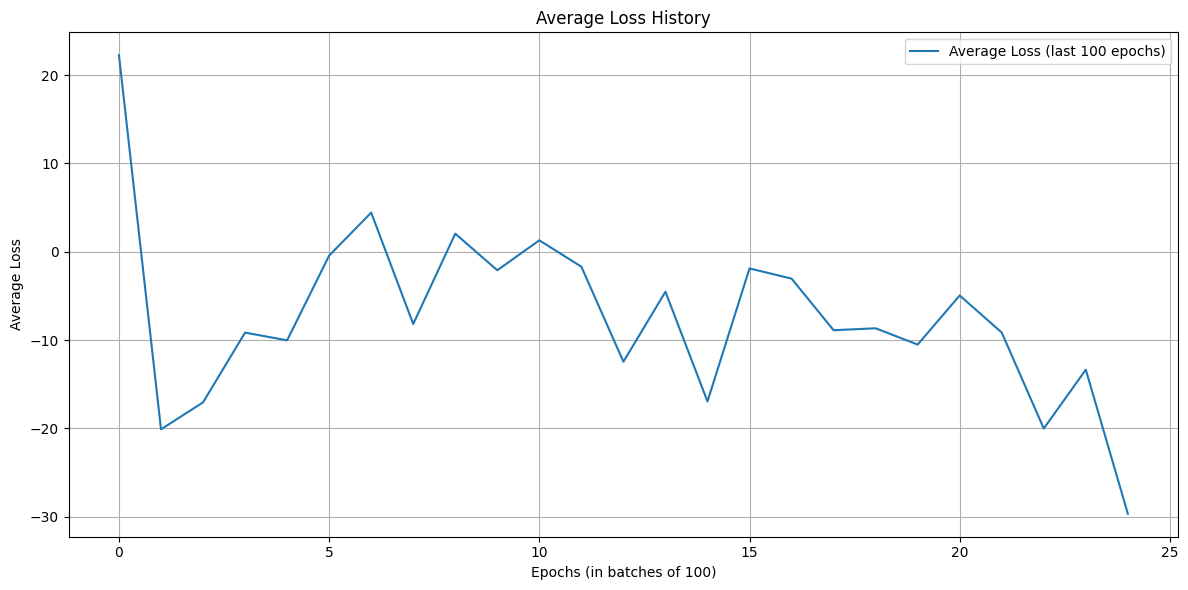

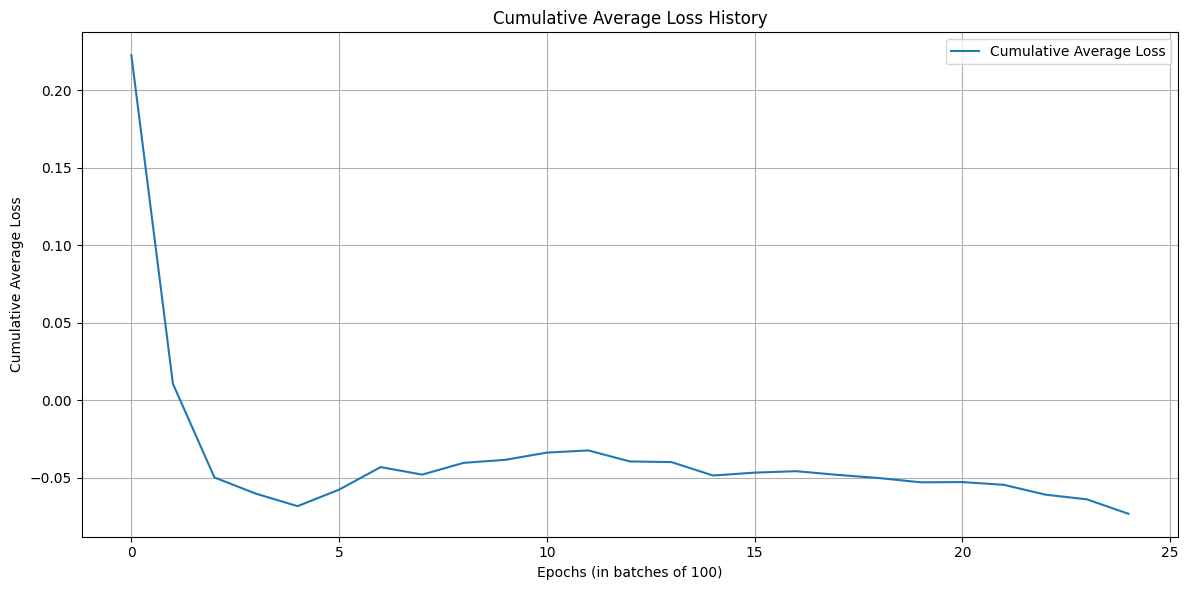

In [10]:
import matplotlib.pyplot as plt
import os

# Create the models directory if it doesn't exist
output_dir = '/content/drive/MyDrive/models'
os.makedirs(output_dir, exist_ok=True)

# Plot Average Loss History
plt.figure(figsize=(12, 6))
plt.plot(loss_histories["avg"], label='Average Loss (last 100 epochs)')
plt.title("Average Loss History")
plt.xlabel("Epochs (in batches of 100)")
plt.ylabel("Average Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'average_loss_history.png'))
plt.show()

# Plot Cumulative Loss History (if available)
if len(loss_histories["cum"]) > 0:
    plt.figure(figsize=(12, 6))
    plt.plot(loss_histories["cum"], label='Cumulative Average Loss')
    plt.title("Cumulative Average Loss History")
    plt.xlabel("Epochs (in batches of 100)")
    plt.ylabel("Cumulative Average Loss")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'cumulative_loss_history.png'))
    plt.show()
else:
    print("Cumulative loss history is empty. Please re-run the training cell after the fix.")

In [11]:
loss_histories["avg"]

[22.257611602544785,
 -20.113588945940137,
 -17.0576164200902,
 -9.15613432135433,
 -10.031799469143152,
 -0.4327870048582554,
 4.433231201022863,
 -8.185100708156824,
 2.049492558930069,
 -2.0942909456789494,
 1.2964468114078045,
 -1.6923448964953423,
 -12.454883757978678,
 -4.5288378512486815,
 -16.95561698032543,
 -1.8902930282056332,
 -3.0413183718919754,
 -8.886565454304218,
 -8.669254510197788,
 -10.511205901391804,
 -4.949908725917339,
 -9.152430420741439,
 -20.021241814363748,
 -13.357258822768927,
 -29.680603040382266]